## Init

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/MyDrive/3_XuLyAnh_Flowers'

In [5]:
%%capture
!pip install accelerate -U
!pip install datasets transformers
!pip install -q torchinfo

## Import lib

In [6]:
# run 11111111
import os
import tarfile
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)
torch.manual_seed(0)

In [7]:
IMG_SIZE      = 224
BATCH_SIZE    = 4
RANDOM_SEED   = 42

## Data

In [44]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [45]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [46]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [47]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [48]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

In [49]:
print(train_files)

                       Id Category
270   jpg/image_00271.jpg       72
6223  jpg/image_06224.jpg       48
263   jpg/image_00264.jpg       72
6210  jpg/image_06211.jpg       48
7678  jpg/image_07679.jpg       95
...                   ...      ...
1266  jpg/image_01267.jpg       73
7647  jpg/image_07648.jpg       95
1612  jpg/image_01613.jpg       81
1151  jpg/image_01152.jpg       73
2552  jpg/image_02553.jpg       83

[1436 rows x 2 columns]


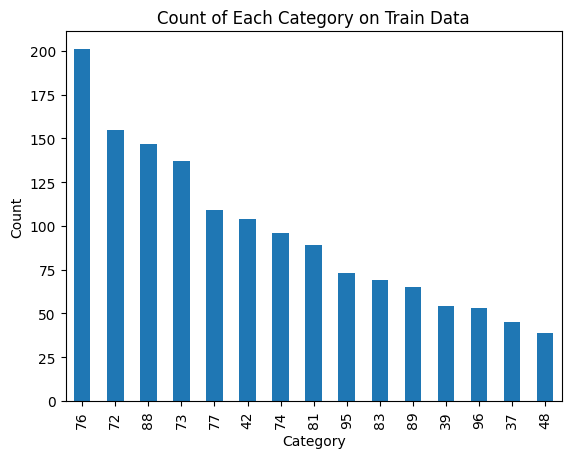

In [50]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

In [51]:
# import pandas as pd
# from datasets import Dataset, Features, Value, Image
# from PIL import Image as PILImage
# import os

# # Đường dẫn gốc của các tệp hình ảnh
# base_path = ''

# # # DataFrame ban đầu
# # data = {
# #     'Id': [
# #         'jpg/image_00271.jpg',
# #         'jpg/image_06224.jpg',
# #         'jpg/image_00264.jpg',
# #         'jpg/image_06211.jpg',
# #         'jpg/image_07679.jpg',
# #         'jpg/image_01267.jpg',
# #         'jpg/image_07648.jpg',
# #         'jpg/image_01613.jpg',
# #         'jpg/image_01152.jpg',
# #         'jpg/image_02553.jpg'
# #     ],
# #     'Category': [72, 48, 72, 48, 95, 73, 95, 81, 73, 83]
# # }
# train_files

# # df = pd.DataFrame(data)

# # Hàm để tạo đường dẫn đầy đủ cho hình ảnh
# def create_image_path(file_id):
#     return os.path.join(base_path, file_id)

# # Tạo cột đường dẫn hình ảnh
# train_files['image_file_path'] = train_files['Id'].apply(create_image_path)

# # Đọc hình ảnh và thêm vào cột 'image'
# def load_image(image_path):
#     return PILImage.open(image_path)

# # train_files['image'] = train_files['image_file_path'].apply(load_image)

# # Đổi tên cột 'Category' thành 'labels'
# train_files.rename(columns={'Category': 'labels'}, inplace=True)

# # Kiểm tra kiểu dữ liệu của cột 'labels' trước khi chuyển đổi
# print(f"Kiểu dữ liệu trước khi chuyển đổi: {type(train_files.iloc[0]['labels'])}")

# # Đảm bảo cột labels là kiểu int64
# train_files['labels'] = train_files['labels'].astype(int)

# # Kiểm tra lại kiểu dữ liệu sau khi chuyển đổi
# print(f"Kiểu dữ liệu sau khi chuyển đổi: {type(train_files.iloc[0]['labels'])}")

# # Chuyển DataFrame thành Dataset của Hugging Face
# features = Features({
#     'image_file_path': Value('string'),
#     # 'image': Image(),
#     'labels': Value('int64')
# })

# dataset = Dataset.from_pandas(train_files, features=features)

# print(dataset)

In [52]:
import pandas as pd
from datasets import Dataset, Features, Value, Image
from PIL import Image as PILImage

# Giả định bạn đã có DataFrame train_files với dữ liệu tương ứng
# base_path để trống nếu bạn không cần thêm đường dẫn gốc vào
base_path = ""

# Hàm để tạo đường dẫn đầy đủ cho hình ảnh
def create_image_path(file_id):
    return base_path + file_id

def load_image(image_path):
    return PILImage.open(image_path)

# Tạo cột đường dẫn hình ảnh
train_files['image_file_path'] = train_files['Id'].apply(create_image_path)
train_files['image'] = train_files['image_file_path'].apply(load_image)

# Đổi tên cột 'Category' thành 'labels'
train_files.rename(columns={'Category': 'labels'}, inplace=True)

# Kiểm tra kiểu dữ liệu của cột 'labels' trước khi chuyển đổi
print(f"Kiểu dữ liệu trước khi chuyển đổi: {type(train_files.iloc[0]['labels'])}")

# Đảm bảo cột labels là kiểu int64
train_files['labels'] = train_files['labels'].astype(int)

# Kiểm tra lại kiểu dữ liệu sau khi chuyển đổi
print(f"Kiểu dữ liệu sau khi chuyển đổi: {type(train_files.iloc[0]['labels'])}")

# Định nghĩa các đặc tính cho Dataset
features = Features({
    'image_file_path': Value('string'),
    'image': Image(),  # Đây là nơi mà thư viện sẽ xử lý các hình ảnh
    'labels': Value('int64')
})

# Kiểm tra tên và kiểu của các cột trong DataFrame
print(train_files.dtypes)

Kiểu dữ liệu trước khi chuyển đổi: <class 'str'>
Kiểu dữ liệu sau khi chuyển đổi: <class 'numpy.int64'>
Id                 object
labels              int64
image_file_path    object
image              object
dtype: object


In [55]:
train_files[['image_file_path', 'image', 'labels']].reset_index(drop=True)

,image_file_path,image,labels
0,jpg/image_00271.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,72
1,jpg/image_06224.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,48
2,jpg/image_00264.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,72
3,jpg/image_06211.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,48
4,jpg/image_07679.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,95
...,...,...,...
1431,jpg/image_01267.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,73
1432,jpg/image_07648.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,95
1433,jpg/image_01613.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,81
1434,jpg/image_01152.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,73


In [59]:
new_df = train_files[['image_file_path', 'image', 'labels']].reset_index(drop=True)
new_df['image'] = new_df['image'].apply(lambda x: np.array(x).flatten())
new_df_arrow = new_df[['image_file_path', 'image', 'labels']].to_arrow()

AttributeError: 'DataFrame' object has no attribute 'to_arrow'

In [58]:
# Chuyển đổi DataFrame thành Dataset, loại bỏ cột index tự động thêm vào
dataset = Dataset.from_pandas(new_df, features=features, preserve_index=False)

# In ra thông tin của Dataset
print(dataset)

ArrowInvalid: ('Can only convert 1-dimensional array values', 'Conversion failed for column image with type object')

In [ ]:
import pandas as pd
from datasets import Dataset, Features, Value, Image

# Giả định bạn đã có DataFrame train_files với dữ liệu tương ứng

# base_path để trống nếu bạn không cần thêm đường dẫn gốc vào
base_path = ""

# Hàm để tạo đường dẫn đầy đủ cho hình ảnh
def create_image_path(file_id):
    return base_path + file_id

# Tạo cột đường dẫn hình ảnh
train_files['image_file_path'] = train_files['Id'].apply(create_image_path)

# Đổi tên cột 'Category' thành 'labels'
train_files.rename(columns={'Category': 'labels'}, inplace=True)

# Định nghĩa các đặc tính cho Dataset
features = Features({
    'image_file_path': Value('string'),
    'image': Image(),  # Đây là nơi mà thư viện sẽ xử lý các hình ảnh
    'labels': Value('int64')
})

# Chuyển đổi DataFrame thành Dataset, loại bỏ cột index tự động thêm vào
dataset = Dataset.from_pandas(train_files[['image_file_path', 'labels']], features=features, preserve_index=False)

# In ra thông tin của Dataset
print(dataset)


### Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

In [ ]:
train_generator.samples

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

In [ ]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## Load Dataset Beans

In [ ]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [ ]:
ex = ds['train'][400]
ex

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

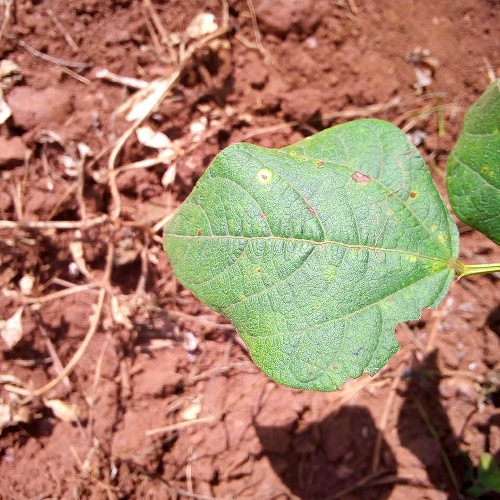

In [ ]:
image = ex['image']
image

In [ ]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [ ]:
print(ex['labels'])
labels.int2str(ex['labels'])

1


'bean_rust'

Show example

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

Output hidden; open in https://colab.research.google.com to view.

## Loading ViT Image Processor

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
print(processor)

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [ ]:
processor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7098,  0.6000,  0.6784,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4902,  0.3882,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8353]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7255, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0588,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9686, -0.9529, -0.9294],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.2941, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4196,  0.2706,  0.3020,  ..., -0.7098, -0.6392, -0.6863],
          [ 0

## Processing the Dataset

In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

In [ ]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

## Training and Evaluation

### Define our data collator

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-18-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.047600,0.050450,0.984962
200,0.040000,0.034171,0.992481


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1135
  train_runtime            =  0:01:44.38
  train_samples_per_second =      39.621
  train_steps_per_second   =       2.491


### Evaluate

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0342
  eval_runtime            = 0:00:02.14
  eval_samples_per_second =     61.935
  eval_steps_per_second   =      7.916
